# Privacy–Utility Trade-off for Code Completion (HumanEval)

This notebook:
1. Loads the first 20 examples from `openai/openai_humaneval` (test split).
2. Builds three prompt variants per example:
   - Original
   - Low obfuscation (variable renaming)
   - High obfuscation (strip comments/docstrings + placeholders)
3. Generates one completion per prompt using `Salesforce/codet5-small` (swap model if desired).
4. Computes:
   - **Utility score**: ROUGE-L (F1) between generated completion and `canonical_solution`
   - **Privacy score**: normalized Levenshtein distance between obfuscated prompt and original prompt
5. Plots Privacy vs Utility.

Notes:
- Utility metric here is intentionally simple; it does not verify correctness.
- Privacy metric here is a proxy for *prompt similarity* (not a formal privacy guarantee).


In [24]:
# If running on Colab:
# !pip install -r ../requirements.txt

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

import sys
from pathlib import Path

# Add project root to PYTHONPATH
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.utils import low_obfuscation, high_obfuscation, privacy_score, utility_score_rougeL

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [25]:
# 1) Load dataset (first 20 examples from test split)

ds = load_dataset("openai/openai_humaneval", split="test")
ds20 = ds.select(range(20))

# Quick peek
ds20[0].keys(), ds20[0]["task_id"]


(dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point']),
 'HumanEval/0')

In [26]:
# 2) Prepare prompt variants

rows = []
for ex in ds20:
    original = ex["prompt"]
    low = low_obfuscation(original)
    high = high_obfuscation(original)
    rows.append({
        "task_id": ex["task_id"],
        "prompt_original": original,
        "prompt_low": low,
        "prompt_high": high,
        "canonical_solution": ex["canonical_solution"],
    })

df = pd.DataFrame(rows)
df.head()


,task_id,prompt_original,prompt_low,prompt_high,canonical_solution
0,HumanEval/0,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\ndef has_close_eleme...,from typing import List\n\ndef has_close_eleme...,"for idx, elem in enumerate(numbers):\n ..."
1,HumanEval/1,from typing import List\n\n\ndef separate_pare...,from typing import List\n\ndef separate_paren_...,from typing import List\n\ndef separate_paren_...,result = []\n current_string = []\n ...
2,HumanEval/2,\n\ndef truncate_number(number: float) -> floa...,def truncate_number(v0: float) -> float:\n ...,def truncate_number(number: float) -> float:,return number % 1.0\n
3,HumanEval/3,from typing import List\n\n\ndef below_zero(op...,from typing import List\n\ndef below_zero(v1: ...,from typing import List\n\ndef below_zero(oper...,balance = 0\n\n for op in operations:\n...
4,HumanEval/4,from typing import List\n\n\ndef mean_absolute...,from typing import List\n\ndef mean_absolute_d...,from typing import List\n\ndef mean_absolute_d...,mean = sum(numbers) / len(numbers)\n re...


In [27]:
# 3) Load model (default: CodeT5-small)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = os.environ.get("MODEL_NAME", "Salesforce/codet5-small")

tok = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

device, model_name


('cpu', 'Salesforce/codet5-small')

In [28]:
def generate_completion(prompt: str,
                        max_new_tokens: int = 128,
                        temperature: float = 0.8,
                        top_p: float = 0.95) -> str:
    """Single sampled completion."""
    inputs = tok(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=max_new_tokens,
            num_return_sequences=1,
            pad_token_id=tok.eos_token_id,
        )
    text = tok.decode(out[0], skip_special_tokens=True)
    return text

# Sanity check (first example, original prompt)
print(df.loc[0, "task_id"])
print(generate_completion(df.loc[0, "prompt_original"])[:500])


HumanEval/0
0.4)
   0.6)0.5)
   False.6)
   3.00.1)
   >None
   =1.1)
   


In [29]:
# 4) Generate 60 completions total

outputs = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    for condition, prompt_col in [("original", "prompt_original"),
                                  ("low", "prompt_low"),
                                  ("high", "prompt_high")]:
        prompt = row[prompt_col]
        prompt = prompt.rstrip() + "\n    # write the function body\n"
        comp = generate_completion(prompt)

        outputs.append({
            "task_id": row["task_id"],
            "condition": condition,
            "prompt_used": prompt,
            "prompt_original": row["prompt_original"],
            "canonical_solution": row["canonical_solution"],
            "completion": comp,
        })

out_df = pd.DataFrame(outputs)
out_df.head()


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


,task_id,condition,prompt_used,prompt_original,canonical_solution,completion
0,HumanEval/0,original,from typing import List\n\n\ndef has_close_ele...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",)function body\n .(print)=`````` return
1,HumanEval/0,low,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",">>>(v1,), v2)endend"
2,HumanEval/0,high,from typing import List\n\ndef has_close_eleme...,from typing import List\n\n\ndef has_close_ele...,"for idx, elem in enumerate(numbers):\n ...",function
3,HumanEval/1,original,from typing import List\n\n\ndef separate_pare...,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,thefunction bodyfunctionfunction.]function bod...
4,HumanEval/1,low,from typing import List\n\ndef separate_paren_...,from typing import List\n\n\ndef separate_pare...,result = []\n current_string = []\n ...,textfunction body(=)function==='(())(())'write...


In [30]:
print("-----Original Prompt-----")
print(out_df.loc[4, "prompt_original"])
print("-----Prompt Used-----")
print(out_df.loc[4, "prompt_used"])
print("-----Canonical Solution-----")
print(out_df.loc[4, "canonical_solution"])
print("-----Completion-----")
print(out_df.loc[4, "completion"])

-----Original Prompt-----
from typing import List


def separate_paren_groups(paren_string: str) -> List[str]:
    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to
    separate those group into separate strings and return the list of those.
    Separate groups are balanced (each open brace is properly closed) and not nested within each other
    Ignore any spaces in the input string.
    >>> separate_paren_groups('( ) (( )) (( )( ))')
    ['()', '(())', '(()())']
    """

-----Prompt Used-----
from typing import List

def separate_paren_groups(v1: str) -> v0[str]:
    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to
    separate those group into separate strings and return the list of those.
    Separate groups are balanced (each open brace is properly closed) and not nested within each other
    Ignore any spaces in the input string.
    >>> separate_paren_groups('( ) (( )) 

In [31]:
# 5) Score utility + privacy

out_df["privacy"] = out_df.apply(lambda r: privacy_score(r["prompt_used"], r["prompt_original"]), axis=1)
out_df["utility"] = out_df.apply(lambda r: utility_score_rougeL(r["completion"], r["canonical_solution"]), axis=1)

out_df.groupby("condition")[["privacy","utility"]].mean()


,privacy,utility
condition,,
high,0.710027,0.049407
low,0.120859,0.051854
original,0.083626,0.028535


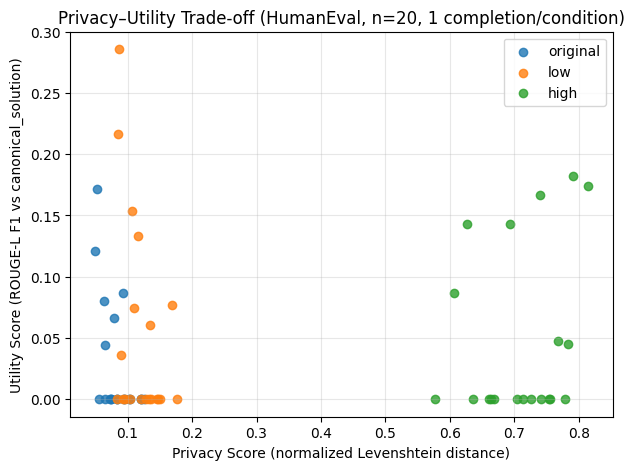

In [32]:
# 6) Scatter plot: Privacy vs Utility

plt.figure(figsize=(7,5))
for cond in ["original", "low", "high"]:
    sub = out_df[out_df["condition"] == cond]
    plt.scatter(sub["privacy"], sub["utility"], label=cond, alpha=0.8)

plt.xlabel("Privacy Score (normalized Levenshtein distance)")
plt.ylabel("Utility Score (ROUGE-L F1 vs canonical_solution)")
plt.title("Privacy–Utility Trade-off (HumanEval, n=20, 1 completion/condition)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Brief analysis (draft)

- **Expected trend**: as obfuscation increases, prompts diverge more from the original (privacy proxy ↑), but the model may lose signal and produce less overlapping text with the canonical solution (utility ↓).
- **Common failure mode**: lexical metrics (ROUGE) can drop even when the completion is functionally correct (e.g., different variable names or alternative implementations).
- **Interpretation caution**: normalized edit distance is not a formal privacy guarantee; it measures only text-level dissimilarity, not whether sensitive semantics can still be inferred.
